# 1. Conceptos relevantes
Estas son las variables que [OpenAQ](https://openaq.org/) ofrece para medir la contaminación del aire. Las definiciones fueron tomadas de la [Ley de Aire Limpio](https://www.epa.gov/criteria-air-pollutants/information-pollutant):

1. PM (Partículas Materiales): Estas partículas vienen en muchos tamaños y formas y pueden estar compuestas de cientos de químicos diferentes. Algunas se emiten directamente de una fuente, como sitios de construcción, caminos sin pavimentar, campos, chimeneas o incendios. La mayoría de las partículas se forman en la atmósfera como resultado de reacciones complejas de químicos como el dióxido de azufre y los óxidos de nitrógeno, que son contaminantes emitidos por plantas de energía, industrias y automóviles.

   - PM₂.₅ (Partículas Materiales de 2.5 micrómetros o más pequeñas):
     partículas inhalables finas, con diámetros que generalmente son de 2.5 micrómetros o más pequeños.

   - PM₁₀ (Partículas Materiales de 10 micrómetros o más pequeñas):
     partículas inhalables, con diámetros que generalmente son de 10 micrómetros o más pequeños.

2. O₃ (Ozono):
   El ozono troposférico, o a nivel del suelo, no se emite directamente al aire, sino que se crea por reacciones químicas entre los óxidos de nitrógeno (NOx) y los compuestos orgánicos volátiles (COV). Esto sucede cuando los contaminantes emitidos por automóviles, plantas de energía, calderas industriales, refinerías, plantas químicas y otras fuentes reaccionan químicamente en presencia de la luz solar.

3. NO₂ (Dióxido de Nitrógeno):
   El dióxido de nitrógeno (NO₂) es uno de un grupo de gases altamente reactivos conocidos como óxidos de nitrógeno (NOx). Otros óxidos de nitrógeno incluyen el ácido nitroso y el ácido nítrico. El NO₂ se utiliza como indicador del grupo más grande de óxidos de nitrógeno. El NO₂ llega principalmente al aire por la quema de combustible. El NO₂ se forma a partir de las emisiones de automóviles, camiones y autobuses, plantas de energía y equipos todoterreno.

4. SO₂ (Dióxido de Azufre):
   El SO₂ es el componente de mayor preocupación y se utiliza como indicador del grupo más grande de óxidos de azufre gaseosos (SOx). Otros SOx gaseosos (como el SO₃) se encuentran en la atmósfera en concentraciones mucho más bajas que el SO₂. La mayor fuente de SO₂ en la atmósfera es la quema de combustibles fósiles por parte de las centrales eléctricas y otras instalaciones industriales. Las fuentes más pequeñas de emisiones de SO₂ incluyen: procesos industriales como la extracción de metal de los minerales; fuentes naturales como los volcanes; y locomotoras, barcos y otros vehículos y equipos pesados que queman combustible con un alto contenido de azufre.

5. CO (Monóxido de Carbono):
   El CO es un gas incoloro e inodoro que puede ser dañino cuando se inhala en grandes cantidades. El CO se libera cuando se quema algo. Las mayores fuentes de CO en el aire exterior son los automóviles, camiones y otros vehículos o maquinaria que queman combustibles fósiles. Una variedad de artículos en su hogar, como calentadores de ambiente de queroseno y gas sin ventilación, chimeneas y hornos con fugas, y estufas de gas también liberan CO y pueden afectar la calidad del aire en interiores.

# 2. Preparar el ambiente y las utilidades

## 2.a Instalar dependencias en google colab

In [119]:
%pip install -q python-dotenv matplotlib numpy pandas requests seaborn cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 94.3 MB/s eta 0:00:00


## 2.b ¿Ejecutando localmente? Instala las dependencias con uv.

Clona el repositorio [https://github.com/andonyns/air-quality/tree/main](https://github.com/andonyns/air-quality/tree/main) y luego, dentro del directorio, ejecuta el siguiente comando:
```bash
pip install uv
```
Luego ejecuta el siguiente comando:
```bash
uv sync
```
Después, abre el cuaderno en Visual Studio Code o Jupyter Notebook y selecciona como kernel el entorno virtual creado por uv dentro del directorio actual.

# 2.c Importar bibliotecas

In [345]:
# For API requests
import requests
from urllib.parse import urljoin

# For env
import os
from dotenv import load_dotenv

from google.colab import userdata

# For data manipulation
from pprint import pprint
import pandas as pd
import pickle as pkl
import numpy as np

import time
import logging
import sys

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import gaussian_filter


## 2.d Funciones de ayuda

In [92]:
def set_color(text: str, color: str = "green") -> str:
    """Set the color of the text using ANSI escape codes.

    Parameters
    ----------
    text : str
        The text to be colored.
    color : str, optional
        The color to apply to the text. Available options are:
        'green', 'yellow', 'red', 'blue', and 'orange'.
        Default is 'green'.

    Returns
    -------
    str
        The text with the specified ANSI color codes applied.
    """
    colors: Dict[str, str] = {
        "green": "\033[32m",
        "yellow": "\033[33m",
        "red": "\033[31m",
        "blue": "\033[34m",
        "orange": "\033[38;5;214m",
        "reset": "\033[0m",
    }
    return f"{colors[color]}{text}{colors['reset']}"


class StdOutLogger():
    """A custom logger that outputs to stdout with colored messages."""

    def __init__(self) -> None:
        """Initialize the StdOutLogger."""
        self.logger = logging.getLogger("Logger")
        self.logger.setLevel(logging.INFO)

        # Avoid duplicate handlers
        if not self.logger.hasHandlers():
            handler = logging.StreamHandler(sys.stdout)
            handler.setLevel(logging.INFO)
            formatter = logging.Formatter(
                "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                datefmt="%Y-%m-%d %H:%M:%S"
            )
            handler.setFormatter(formatter)
            self.logger.addHandler(handler)

    def info(self, message: str) -> None:
        """Log an info-level message.

        Parameters
        ----------
        message : str
            The message to log.
        """
        self.logger.info(message)

    def highlight(self, message: str) -> None:
        """Log a highlighted message in blue.

        Parameters
        ----------
        message : str
            The message to log.
        """
        self.logger.info(set_color(message, "blue"))

    def success(self, message: str) -> None:
        """Log an info-level success message in green.

        Parameters
        ----------
        message : str
            The success message to log.
        """
        self.logger.info(set_color(message, "green"))

    def warning(self, message: str) -> None:
        """Log a warning-level message in orange.

        Parameters
        ----------
        message : str
            The warning message to log.
        """
        self.logger.warning(set_color(message, "orange"))

    def critical(self, message: str) -> None:
        """Log a critical-level message in red.

        Parameters
        ----------
        message : str
            The critical message to log.
        """
        self.logger.critical(set_color(message, "red"))

    def error(self, message: str) -> None:
        """Log a error-level message in red.

        Parameters
        ----------
        message : str
            The critical message to log.
        """
        self.logger.critical(set_color(message, "red"))

Instanciamos un logger y cargamos las variables de ambiente para obtener API_KEY.

In [93]:
logger = StdOutLogger()
load_dotenv()

False

## 2.e Constantes

In [33]:
DATA_DIR = "data"
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

BASE_API_URL = "https://api.openaq.org/v3/"

HEADERS = { "X-API-Key": os.getenv("API_KEY") or userdata.get("API_KEY") }

LOCATIONS_ENDPOINT = urljoin(BASE_API_URL, "locations/{location_id}")
MEASUREMENTS_ENDPOINT = urljoin(BASE_API_URL, "sensors/{sensor_id}/measurements")

## 2.f Cliente básico para obtener datos de OpenAQ


In [28]:
class OpenAQClient:
    """A static client for interacting with the OpenAQ API."""

    _base_url: str = BASE_API_URL
    _headers: dict = {"X-API-Key": os.getenv("API_KEY")}
    _logger: logging.Logger = logger

    @staticmethod
    def set_config(
        base_api_url: str = BASE_API_URL,
        api_key: str | None = None,
        logger: logging.Logger | None = None,
    ) -> None:
        """Configure the OpenAQClient.

        This method sets the base URL, API key, and logger for all
        subsequent requests.  It's a class method, so it's called on
        the class itself (e.g., OpenAQClient.set_config(...)).

        Parameters
        ----------
        base_api_url : str, optional
            The base URL for the OpenAQ API.  Default is the module-level
            BASE_API_URL.
        api_key : str, optional
            The API key for OpenAQ. If None, it will try to get it from
            the environment variable "API_KEY". Default is None.
        logger : logging.Logger, optional
            The logger to use.  Default is the module-level logger.
        """
        OpenAQClient._base_url = base_api_url
        OpenAQClient._headers = {"X-API-Key": api_key or os.getenv("API_KEY") or userdata.get("API_KEY")}
        OpenAQClient._logger = logger or logging.getLogger(__name__)

    @staticmethod
    def _fetch_data(
        endpoint: str,
        parameters: dict | None = None,
        query_parameters: dict | None = None,
        verbose: bool = False,
    ) -> requests.Response:
        """Fetch data from a given API endpoint.

        This is a static method, so it's called on the class
        (e.g., OpenAQClient._fetch_data(...)).

        Parameters
        ----------
        endpoint : str
            The specific endpoint URL (relative to the base URL).
        parameters : dict of str to any, optional
            Path parameters to format the endpoint URL.
        query_parameters : dict of str to any, optional
            Query parameters to append to the URL.
        verbose : bool, optional
            If True, print the response headers.

        Returns
        -------
        requests.Response
            The raw requests.Response object.

        Raises
        ------
        Exception
            If the HTTP request returns a status code other than 200.
        """
        url = urljoin(OpenAQClient._base_url, endpoint)

        if parameters:
            url = url.format(**parameters)

        if query_parameters:
            url += "?" + "&".join(f"{k}={v}" for k, v in query_parameters.items())

        response = requests.get(url=url, headers=OpenAQClient._headers)

        if response.status_code != 200:
            raise Exception(
                f"Request failed with status: {response.status_code}. Reason: {response.text}"
            )

        if verbose:
            OpenAQClient._logger.info(response.headers)

        return response

    @staticmethod
    def fetch_location_sensors_data(
        location_id: int,
        locations_endpoint: str = "locations/{location_id}",
        measures_endpoint: str = "sensors/{sensor_id}/measurements"
    ) -> dict:
        """Fetch sensor data for a specific location.

        This is a static method, so it's called on the class.

        Parameters
        ----------
        location_id : int
            The ID of the location.

        Returns
        -------
        dict
            A dictionary where keys are sensor IDs and values are lists of
            measurement data pages.
        """
        OpenAQClient._logger.info(f"Fetching data for location ID: {location_id}...")
        try:
            location_response = OpenAQClient._fetch_data(
                endpoint=locations_endpoint,
                parameters={"location_id": location_id}
            )
            location_data = location_response.json()
            OpenAQClient._logger.success(
                f"Finished fetching location data for ID: {location_id}"
            )
        except Exception as e:
            OpenAQClient._logger.critical(
                f"Error fetching location data for ID {location_id}: {e}"
            )
            return {}

        sensors_data: dict = {}
        sensors = location_data["results"][0].get("sensors", [])

        for i, sensor in enumerate(sensors):
            sensor_id = sensor["id"]
            sensors_data[sensor_id] = []
            query_params: dict = {"limit": 100, "page": 1}
            OpenAQClient._logger.info(
                f"Processing sensor ID: {sensor_id} (sensor {i + 1}/{len(sensors)})"
            )

            while True:
                try:
                    measurements_response = OpenAQClient._fetch_data(
                        endpoint=measures_endpoint,
                        parameters={"sensor_id": sensor_id},
                        query_parameters=query_params,
                    )
                    measurements_data = measurements_response.json()
                    OpenAQClient._logger.info(
                        f"Processing sensor ID {sensor_id}, page {measurements_data['meta']['page']}"
                    )
                    OpenAQClient._logger.warning(
                        f"Remaining requests: {measurements_response.headers.get('X-Ratelimit-Remaining', 'N/A')}"
                    )
                    sensors_data[sensor_id].append(measurements_data)

                    if len(measurements_data["results"]) < 100:
                        break

                    rate_limit_remaining = measurements_response.headers.get(
                        "X-Ratelimit-Remaining"
                    )
                    rate_limit_reset = measurements_response.headers.get(
                        "X-Ratelimit-Reset"
                    )
                    if rate_limit_remaining == "1" and rate_limit_reset is not None:
                        OpenAQClient._logger.warning(
                            f"Reached rate limit for sensor {sensor_id}. Waiting for {rate_limit_reset} seconds."
                        )
                        time.sleep(int(rate_limit_reset))
                    query_params["page"] += 1
                except Exception as e:
                    OpenAQClient._logger.error(
                        f"Error fetching measurements for sensor ID {sensor_id}: {e}"
                    )
                    break

            OpenAQClient._logger.success(f"Finished processing sensor ID: {sensor_id}")

        OpenAQClient._logger.success(
            f"Finished processing all sensors for location ID: {location_id}"
        )
        return sensors_data

In [29]:
OpenAQClient.set_config(
    base_api_url=BASE_API_URL,
    api_key=os.getenv("API_KEY"),
    logger=logger,
)

### Ejemplo de CR

Podemos obtener los datos de una localización llamando a la función y accediendo al endpoint de las localizaciones. De antemano, se buscó el ID de la localización existente en [Explore the data](https://explore.openaq.org/#1.2/20/40). Así se usa esto como parámetro para obtener la información de la localización.

In [30]:
# Costa Rica example
cr_location_id = 3070644

cr_location_data = OpenAQClient._fetch_data(
    endpoint=LOCATIONS_ENDPOINT,
    parameters={"location_id": cr_location_id},
).json()
pprint(cr_location_data)

{'meta': {'found': 1,
          'limit': 100,
          'name': 'openaq-api',
          'page': 1,
          'website': '/'},
 'results': [{'bounds': [-84.0417, 9.938, -84.0417, 9.938],
              'coordinates': {'latitude': 9.938, 'longitude': -84.0417},
              'country': {'code': 'CR', 'id': 29, 'name': 'Costa Rica'},
              'datetimeFirst': {'local': '2024-09-19T14:01:34-06:00',
                                'utc': '2024-09-19T20:01:34Z'},
              'datetimeLast': {'local': '2025-04-25T09:53:23-06:00',
                               'utc': '2025-04-25T15:53:23Z'},
              'distance': None,
              'id': 3070644,
              'instruments': [{'id': 4, 'name': 'Clarity Sensor'}],
              'isMobile': False,
              'isMonitor': False,
              'licenses': [{'attribution': {'name': 'Clarity', 'url': None},
                            'dateFrom': '2021-10-20',
                            'dateTo': None,
                            'id

Específicamente, este endpoint extrae, entre otras cosas, la información de los sensores que toman datos allí. Con esta información es posible obtener la información de los datos que han medido los sensores a través del tiempo.

En este caso, y a modo de ejemplo, vamos a obtener la información del primer sensor de Costa Rica.

In [31]:
# Get the first sensor
sensor = cr_location_data["results"][0]["sensors"][0]
not_finished = True
query_params = {"limit": 1000, "page": 1}

while not_finished:
    sensor_id = sensor["id"]
    sensor_data = OpenAQClient._fetch_data(
        endpoint=MEASUREMENTS_ENDPOINT,
        parameters={"sensor_id": sensor_id},
        query_parameters=query_params,
    ).json()
    if len(sensor_data["results"]) < 1000:
        print(f"last page: {sensor_data['meta']['page']}")
        not_finished = False

    else:
        query_params["page"] += 1

print(f"Total pages: {query_params['page']}")

last page: 13
Total pages: 13


Agrupando las mediciones por día, se obtiene una granularidad decente para el análisis de los datos, pues muchos países no tiene una única página de datos como Costa Rica, si no que tiene muchísimas páginas más.

Vamos a hacer una función para obtener la información de todas las páginas de medidas que arroja el endpoint.

### Obtención de datos de todas las localizaciones

Por comodidad, también podemos hacer una clase localización, que guarde datos básicos de ella y además los datos de sus sensores.

In [233]:
class Location:
    def __init__(
        self,
        country: str,
        name: str,
        id: int,
        sensors_data: dict = None,
    ) -> None:
        self.country: str = country
        self.name: str = name
        self.id: int = id
        self.sensors_data: dict = sensors_data
        self.coordinates: tuple[float, float] = None
        self.file_path: str = f"{DATA_DIR}/{country}_{name}/{country}_{name}"

    def pull_location_data(self):
        location_data = OpenAQClient._fetch_data(
            endpoint="locations/{location_id}",
            parameters={"location_id": location.id},
        ).json()

        self.coordinates = location_data['results'][0]['coordinates']


    def pull_sensors_data(self, grouped_by: str = None) -> None:
        if grouped_by is None:
          self.sensors_data = OpenAQClient.fetch_location_sensors_data(self.id)
        else:
          self.sensors_data = OpenAQClient.fetch_location_sensors_data(
              self.id,
              measures_endpoint="sensors/{sensor_id}/measurements/" + grouped_by
          )

    @staticmethod
    def save(location: "Location") -> None:
        if not os.path.isdir(DATA_DIR + f"/{location.country}_{location.name}"):
            os.mkdir(DATA_DIR + f"/{location.country}_{location.name}")

        with open(f"{location.file_path}.pkl", "wb") as f:
            pkl.dump(location, f)

    @staticmethod
    def load(location: "Location") -> "Location":
        with open(f"{location.file_path}.pkl", "rb") as f:
            location = pkl.load(f)

        return location

In [234]:
locations = [
    Location(
        country="Costa Rica",
        name="NASA GSFC Rutgers Calib. N13",
        id=3070644,
    ),
    Location(
        country="Reino Unido",
        name="UAL Creative Computing Institute, Greencoat Building",
        id=1462792,
    ),
    Location(
        country="Vietnam",
        name="CMT8",
        id=3276359,
    ),
    Location(
        country="Ghana",
        name="Afri-SET",
        id=2453500,
    ),
    Location(
        country="Mumbai",
        name="Mahape, Navi Mumbai",
        id=6943,
    ),
    Location(
        country="California",
        name="Puente Plaza",
        id=3046642,
    ),
]

Vamos a obtener los datos agrupados por día para cada localización. Sería posible obtener cada una de las mediciones individuales, sin embargo, el endpoint no está optimizado para que le soliciten tantas páginas. Mientras más alto es el número de página que se le solicita, más lenta va a ser la respuesta. El servidor finaliza la solicitud si tarda demasiado. Ejecute esta celda para ver el comportamiento descrito:

In [36]:
# For every location, save all info
for location in locations:
    # No grouping
    location.pull_sensors_data(grouped_by=None)
    Location.save(location)

    del location.sensors_data

    logger.success(f"Saved data for location {location.name}")

Streaming output truncated to the last 5000 lines.
INFO:Logger:Processing sensor ID 6794731, page 57
INFO:Logger:Processing sensor ID 6794731, page 58
INFO:Logger:Processing sensor ID 6794731, page 59
INFO:Logger:Processing sensor ID 6794731, page 60
INFO:Logger:Processing sensor ID 6794731, page 61
INFO:Logger:Processing sensor ID 6794731, page 62
INFO:Logger:Processing sensor ID 6794731, page 63
INFO:Logger:Processing sensor ID 6794731, page 64
INFO:Logger:Processing sensor ID 6794731, page 65
INFO:Logger:Processing sensor ID 6794731, page 66
INFO:Logger:Processing sensor ID 6794731, page 67
INFO:Logger:Processing sensor ID 6794731, page 68
INFO:Logger:Processing sensor ID 6794731, page 69
INFO:Logger:Processing sensor ID 6794731, page 70
INFO:Logger:Processing sensor ID 6794731, page 71
INFO:Logger:Processing sensor ID 6794731, page 72
INFO:Logger:Processing sensor ID 6794731, page 73
INFO:Logger:Processing sensor ID 6794731, page 74
INFO:Logger:Processing sensor ID 6794731, page 75

Por lo tanto, **se prefirió hacer las solicitudes agrupadas por día**, que todavía son suficientemente representativas.

In [144]:
# For every location, save all info
for location in locations:
    # Set daily group
    location.pull_location_data()
    location.pull_sensors_data(grouped_by="daily")
    Location.save(location)

    del location.sensors_data

    logger.success(f"Saved data for location {location.name}")

INFO:Logger:Fetching data for location ID: 3070644...
INFO:Logger:Finished fetching location data for ID: 3070644
INFO:Logger:Processing sensor ID: 10669679 (sensor 1/1)
INFO:Logger:Processing sensor ID 10669679, page 1
INFO:Logger:Processing sensor ID 10669679, page 2
INFO:Logger:Processing sensor ID 10669679, page 3
INFO:Logger:Finished processing sensor ID: 10669679
INFO:Logger:Finished processing all sensors for location ID: 3070644
INFO:Logger:Saved data for location NASA GSFC Rutgers Calib. N13
INFO:Logger:Fetching data for location ID: 1462792...
INFO:Logger:Finished fetching location data for ID: 1462792
INFO:Logger:Processing sensor ID: 7979234 (sensor 1/8)
INFO:Logger:Processing sensor ID 7979234, page 1
INFO:Logger:Finished processing sensor ID: 7979234
INFO:Logger:Processing sensor ID: 7970863 (sensor 2/8)
INFO:Logger:Processing sensor ID 7970863, page 1
INFO:Logger:Processing sensor ID 7970863, page 2
INFO:Logger:Processing sensor ID 7970863, page 3
INFO:Logger:Processing 


# 3. Tareas de limpieza y transformación:

Se deben realizar las tareas de limpieza y transformación necesarias para poder hacer un comparativo de la evolución de los diferentes indicadores de la calidad del aire en Costa Rica y las otras ciudades.


In [235]:
# Load the data
locations = [Location.load(location) for location in locations]

## 3.a Paso a csv

Primero, vamos a eliminar los datos que no interesan y quedarnos con los que son relevantes para hacer análisis

In [254]:
def location_to_pd(location_data: Location) -> pd.DataFrame:
    """Convert location measurement data into a pandas DataFrame.

    Extracts individual sensor measurements from the nested structure
    within a Location object (typically obtained from an API client like
    OpenAQClient) and organizes them into a flat DataFrame format.

    Parameters
    ----------
    location_data : Location
        An object representing a specific location. It is expected to have
        attributes: `id` (int), `name` (str), `country` (str), and
        `sensors_data` (dict). The `sensors_data` attribute should be a
        dictionary mapping sensor IDs to lists of page results. Each page
        is expected to be a dictionary containing a 'results' key, which
        maps to a list of individual measurement dictionaries.

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row represents a single measurement period
        for a specific sensor at the given location. Columns include:
        'location_id', 'location_name', 'sensor_id', 'from_date',
        'to_date', 'parameter_name', 'parameter_units', 'value',
        'aggregated_count', 'summary_avg', 'summary_max', 'summary_median',
        'summary_min', 'summary_q02', 'summary_q25', 'summary_q75',
        'summary_q98', 'summary_sd'.

    Notes
    -----
    Assumes the nested structure of `location_data.sensors_data` where
    measurements are contained within pages under the 'results' key.
    The structure typically originates from paginated API responses.

    """
    rows = []
    location_name = location_data.name
    country_name = location.country

    for sensor_id, sensor_pages in location_data.sensors_data.items():
        for page in sensor_pages:
            measurements = page.get("results", [])

            for measurement in measurements:
                period = measurement.get("period", {})
                datetime_from = period.get("datetimeFrom", {})
                datetime_to = period.get("datetimeTo", {})
                parameter = measurement.get("parameter", {})
                coverage = measurement.get("coverage", {})
                summary = measurement.get("summary", {})

                rows.append(
                    [
                        location_data.id,
                        country_name,
                        location_name,
                        sensor_id,
                        datetime_from.get("utc"),
                        datetime_to.get("utc"),
                        parameter.get("name"),
                        parameter.get("units"),
                        measurement.get("value"),
                        coverage.get("observedCount"),
                        summary.get("avg"),
                        summary.get("max"),
                        summary.get("median"),
                        summary.get("min"),
                        summary.get("q02"),
                        summary.get("q25"),
                        summary.get("q75"),
                        summary.get("q98"),
                        summary.get("sd"),
                    ]
                )

    columns = [
        "location_id",
        "country_name",
        "location_name",
        "sensor_id",
        "from_date",
        "to_date",
        "parameter_name",
        "parameter_units",
        "value",
        "aggregated_count",
        "summary_avg",
        "summary_max",
        "summary_median",
        "summary_min",
        "summary_q02",
        "summary_q25",
        "summary_q75",
        "summary_q98",
        "summary_sd",
    ]

    return pd.DataFrame(rows, columns=columns)

In [255]:
for location in locations:
    df = location_to_pd(location)
    df.to_csv(f"{location.file_path}.csv", index=False)

In [297]:
locations_dfs = [pd.read_csv(f"{location.file_path}.csv") for location in locations]

## 3.b Descripción de los datos

Veamos si hay valores nulos en alguno de los data frames.

In [257]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"DataFrame null values: {df.isnull().sum()}")

INFO:Logger:Location: Costa Rica NASA GSFC Rutgers Calib. N13
INFO:Logger:DataFrame null values: location_id         0
country_name        0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q98         0
summary_sd          0
dtype: int64
INFO:Logger:Location: Reino Unido UAL Creative Computing Institute, Greencoat Building
INFO:Logger:DataFrame null values: location_id          0
country_name         0
location_name        0
sensor_id            0
from_date            0
to_date              0
parameter_name       0
parameter_units      0
value                0
aggregated_count     0
summary_avg          0
summary_max          0
summary_median       0
summary_min          0
summary_q02          0
summa

Aparentemente hay valores nulos en el campo de "sd". Estos son datos en donde el proceso de agregado solo tenía un elemento, por lo que no hay una desviación estándar para los datos de ese día. Esto no es preocupante, pero se deben cambiar estos datos a un 0.

In [132]:
for df in locations_dfs:
    df["summary_sd"] = df["summary_sd"].replace({np.nan: 0})

Verifiquemos nuevamente la cantidad de nulos.

In [258]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"DataFrame null values: \n{df.isnull().sum()}")

INFO:Logger:Location: Costa Rica NASA GSFC Rutgers Calib. N13
INFO:Logger:DataFrame null values: 
location_id         0
country_name        0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q98         0
summary_sd          0
dtype: int64
INFO:Logger:Location: Reino Unido UAL Creative Computing Institute, Greencoat Building
INFO:Logger:DataFrame null values: 
location_id          0
country_name         0
location_name        0
sensor_id            0
from_date            0
to_date              0
parameter_name       0
parameter_units      0
value                0
aggregated_count     0
summary_avg          0
summary_max          0
summary_median       0
summary_min          0
summary_q02          0
sum

Hemos limpiado los datos y están listos para el análisis.

In [259]:
for df, location in zip(locations_dfs, locations):
    df.to_csv(f"{location.file_path}_cleaned.csv", index=False)


# 4. Análisis y comparación:

Se debe realizar un análisis EDA que incluya análisis univariable y multivariable.

Analizar las tendencias de los indicadores para las diferentes ciudades y hacer comparaciones entre diferentes países y ciudades.

Incluir posibles correlaciones entre las variables y parámetros de calidad del aire de cada país/ciudad.

Utilizar diferentes tipos de visualizaciones relevantes para el análisis.



## 4.a Localizaciones

Podemos visualizar las localizaciones.

In [273]:
# Get a colormap
cmap = plt.get_cmap('Set1')

# Create a list of colors based on the number of locations
colors = [cmap(i / len(locations)) for i in range(len(locations))]

locations_color_map = {}
for i, location in enumerate(locations):
  locations_color_map[location.country] = colors[i]

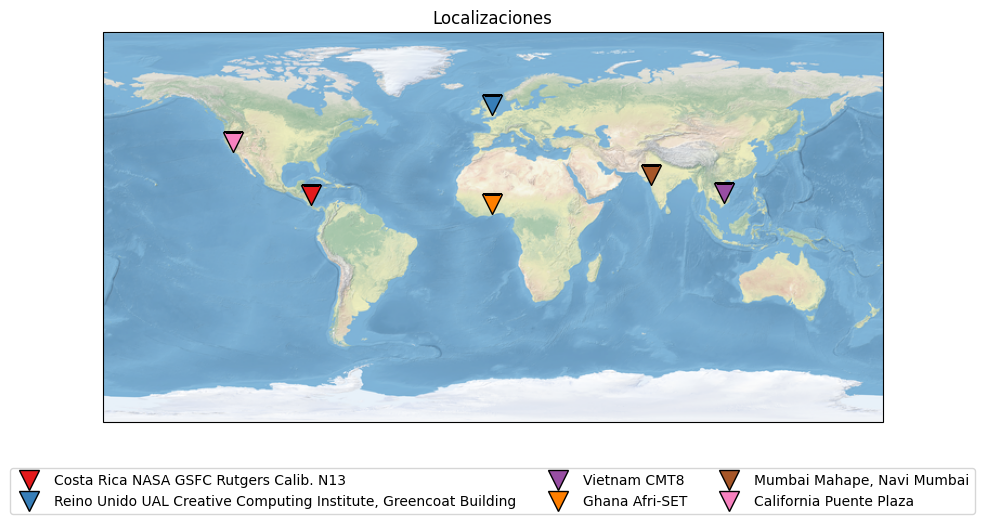

In [261]:
# Setup the map
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.stock_img()

# Plot each location on the map
for i, location in enumerate(locations):
    longitude = location.coordinates['longitude']
    # We add a little offset to move the triangle tip to point
    latitude = location.coordinates['latitude'] + 5

    color = locations_color_map[location.country]

    ax.plot(
        longitude,
        latitude,
        label=location.country + " " + location.name,
        color=color,
        marker='v',
        markeredgewidth=1,
        markeredgecolor='black',
        markersize=15,
        linestyle='None',
        transform=ccrs.PlateCarree()
    )

# Legend with colors
ax.legend(
    loc='upper center',
    fontsize=10,
    bbox_to_anchor=(0.5, -0.1),
    ncol=3
)
plt.title("Localizaciones")
plt.tight_layout()
plt.show()

## 4.a Análisis descriptivo

Veamos la cantidad de datos en cada localización.

In [278]:
data = []

for df, location in zip(locations_dfs, locations):
    data.append({
        "Pais": location.country,
        "Localizacion": location.name,
        "Datos": df.shape[0]
    })

data_df = pd.DataFrame(data)
data_df = data_df.sort_values(by="Datos", ascending=False)
data_df

,Pais,Localizacion,Datos
4,Mumbai,"Mahape, Navi Mumbai",5877
1,Reino Unido,"UAL Creative Computing Institute, Greencoat Bu...",2365
3,Ghana,Afri-SET,2268
5,California,Puente Plaza,1162
2,Vietnam,CMT8,712
0,Costa Rica,NASA GSFC Rutgers Calib. N13,202


<Figure size 1000x800 with 0 Axes>

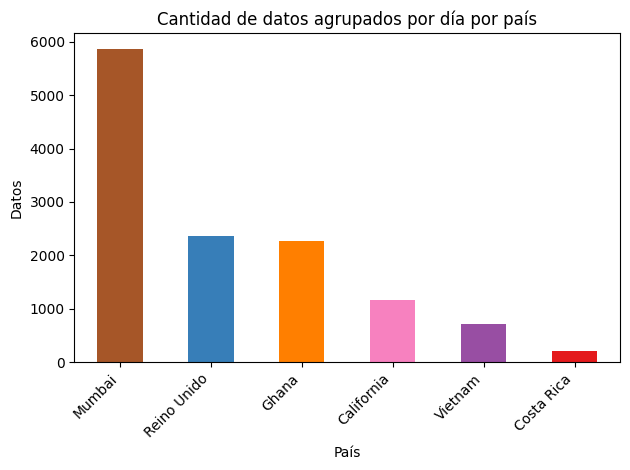

In [279]:
ordered_colors = [locations_color_map[country] for country in data_df['Pais'].tolist()]

# Create the bar plot
plt.figure(figsize=(10, 8))
ax = data_df.plot(
    kind='bar',
    x='Pais',
    y='Datos',
    color=ordered_colors,
    legend=False
)

# Rotate x-ticks
plt.xticks(rotation=45, ha='right')

plt.xlabel('País')
plt.ylabel('Datos')
plt.title('Cantidad de datos agrupados por día por país')

plt.tight_layout()
plt.show()

Mumbai es el país con más datos de todos, con una diferencia importante. Reino Unido y Ghana tienen una cantidad similar, y los que menos datos tienen son California, Vietnam y Costa Rica.

No obstante, hay que recordar que estos números son días completos y no mediciones individuales. Es decir, están agrupados por días. La cantidad real de datos recolectados en cada localización es la siguiente:

In [275]:
data = []

for df, location in zip(locations_dfs, locations):
    data.append({
        "Pais": location.country,
        "Localizacion": location.name,
        "Datos": df['aggregated_count'].sum()
    })

data_df = pd.DataFrame(data)
data_df = data_df.sort_values(by="Datos", ascending=False)
data_df

,Pais,Localizacion,Datos
4,Mumbai,"Mahape, Navi Mumbai",189076
1,Reino Unido,"UAL Creative Computing Institute, Greencoat Bu...",52069
3,Ghana,Afri-SET,50120
5,California,Puente Plaza,27161
2,Vietnam,CMT8,16216
0,Costa Rica,NASA GSFC Rutgers Calib. N13,12571


<Figure size 1000x800 with 0 Axes>

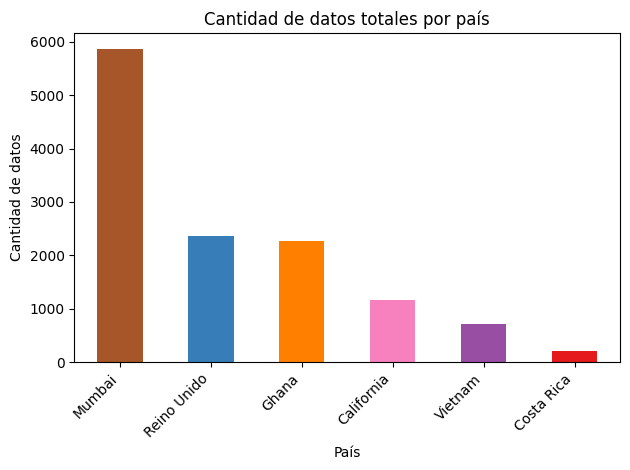

In [281]:
ordered_colors = [locations_color_map[country] for country in data_df['Pais'].tolist()]

# Create the bar plot
plt.figure(figsize=(10, 8))
ax = data_df.plot(
    kind='bar',
    x='Pais',
    y='Datos',
    color=ordered_colors,
    legend=False
)

# Rotate x-ticks
plt.xticks(rotation=45, ha='right')

plt.xlabel('País')
plt.ylabel('Cantidad de datos')
plt.title('Cantidad de datos totales por país')

plt.tight_layout()
plt.show()

Vemos que con los datos reales, la diferencia es todavía más grande.

Por último, podemos describir los datos numéricos en cada data frame.

In [266]:
import pandas as pd

for df, location in zip(locations_dfs, locations):
    logger.highlight(f"Location: {location.country} {location.name}")
    description = df.describe().to_string()

    logger.info(f"Description:\n{description}")

INFO:Logger:Location: Costa Rica NASA GSFC Rutgers Calib. N13
INFO:Logger:Description:
       location_id   sensor_id       value  aggregated_count  summary_avg  summary_max  summary_median  summary_min  summary_q02  summary_q25  summary_q75  summary_q98  summary_sd
count        202.0       202.0  202.000000        202.000000   202.000000   202.000000      202.000000   202.000000   202.000000   202.000000   202.000000   202.000000  202.000000
mean     3070644.0  10669679.0    6.075990         62.232673     6.075782     9.005099        5.924035     4.468960     4.567004     5.279270     6.728366     8.369921    1.079231
std            0.0         0.0    1.351398         14.643027     1.350955     3.151860        1.337876     0.777266     0.824908     1.118061     1.706693     2.545872    0.637755
min      3070644.0  10669679.0    4.010000          4.000000     4.005652     5.010000        3.890000     3.410000     3.420000     3.660000     4.270000     4.825600    0.105317
25%      3070

# Poner analisis del describe aca

In [267]:
for df, location in zip(locations_dfs, locations):
    logger.highlight(f"Location: {location.country} {location.name}")
    logger.info(
        f"Parameters measured in location: \n{df[['parameter_name', 'parameter_units']].drop_duplicates().to_string()}"
    )

INFO:Logger:Location: Costa Rica NASA GSFC Rutgers Calib. N13
INFO:Logger:Parameters measured in location: 
  parameter_name parameter_units
0           pm25           µg/m³
INFO:Logger:Location: Reino Unido UAL Creative Computing Institute, Greencoat Building
INFO:Logger:Parameters measured in location: 
        parameter_name parameter_units
0                  pm1           µg/m³
357               pm10           µg/m³
640               pm25           µg/m³
1154  relativehumidity               %
1508       temperature               c
2022             um003   particles/cm³
INFO:Logger:Location: Vietnam CMT8
INFO:Logger:Parameters measured in location: 
       parameter_name parameter_units
0                 pm1           µg/m³
131              pm10           µg/m³
188              pm25           µg/m³
319  relativehumidity               %
450       temperature               c
581             um003   particles/cm³
INFO:Logger:Location: Ghana Afri-SET
INFO:Logger:Parameters measured in l

## 3.c Análisis univariable

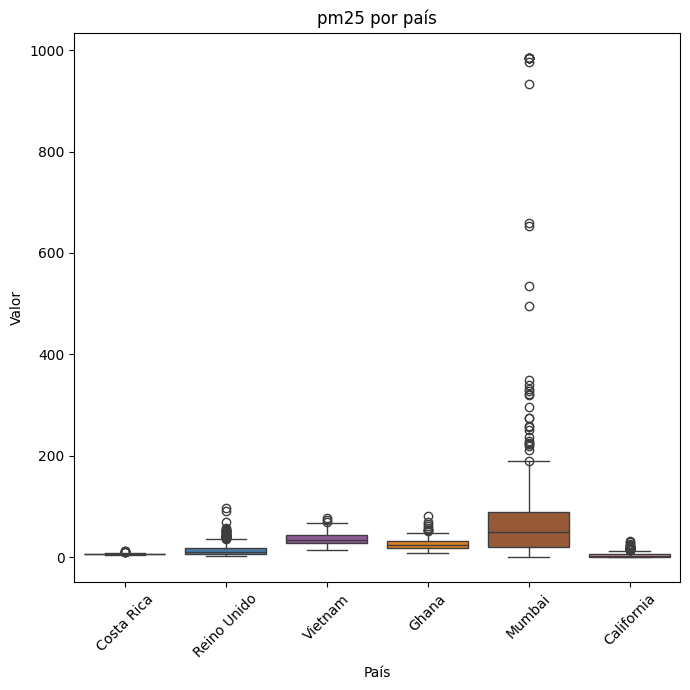

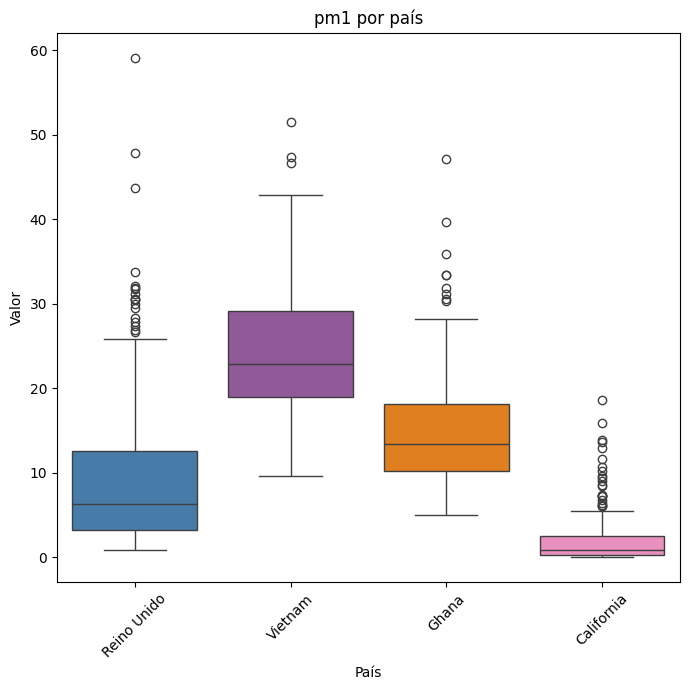

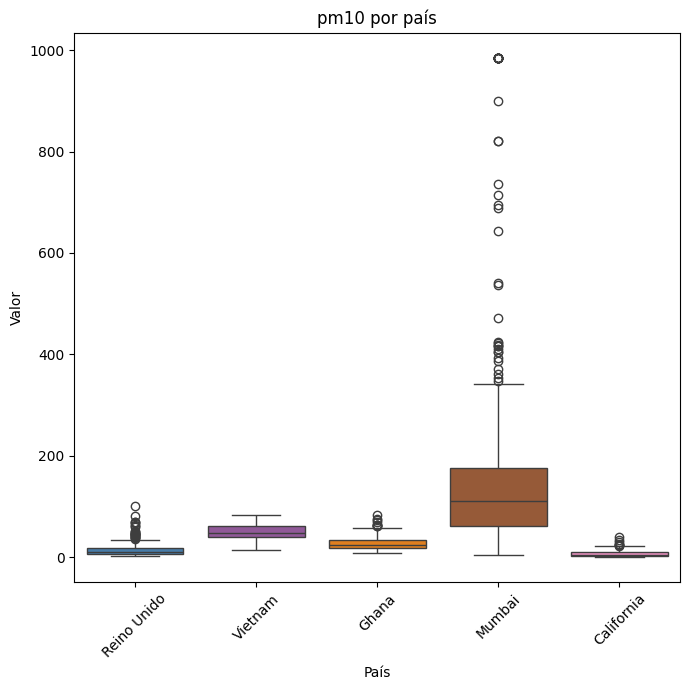

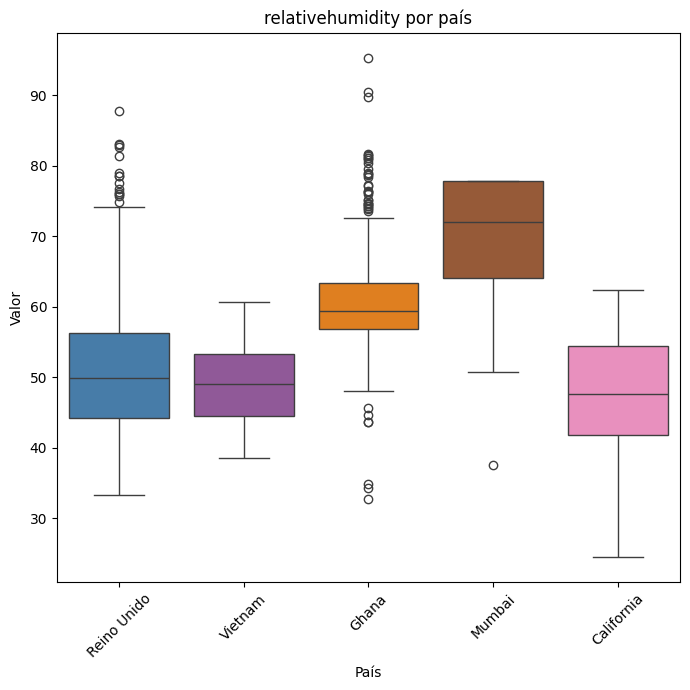

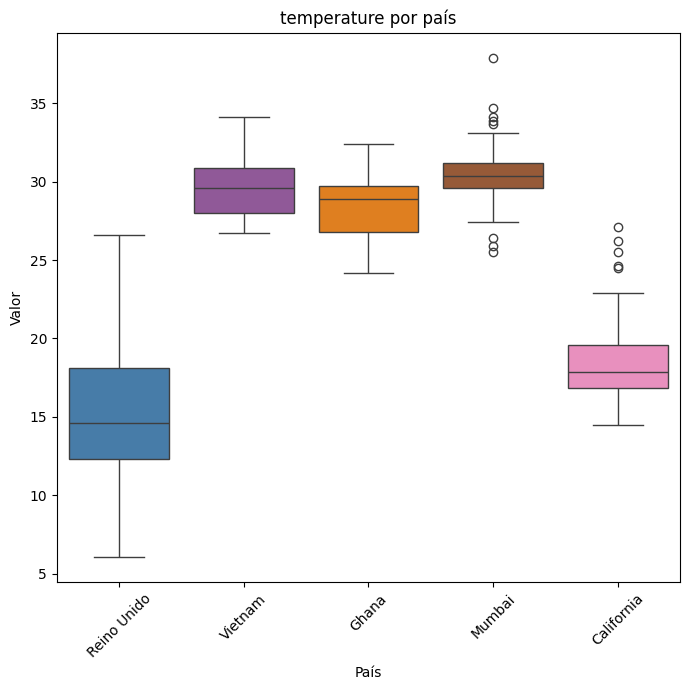

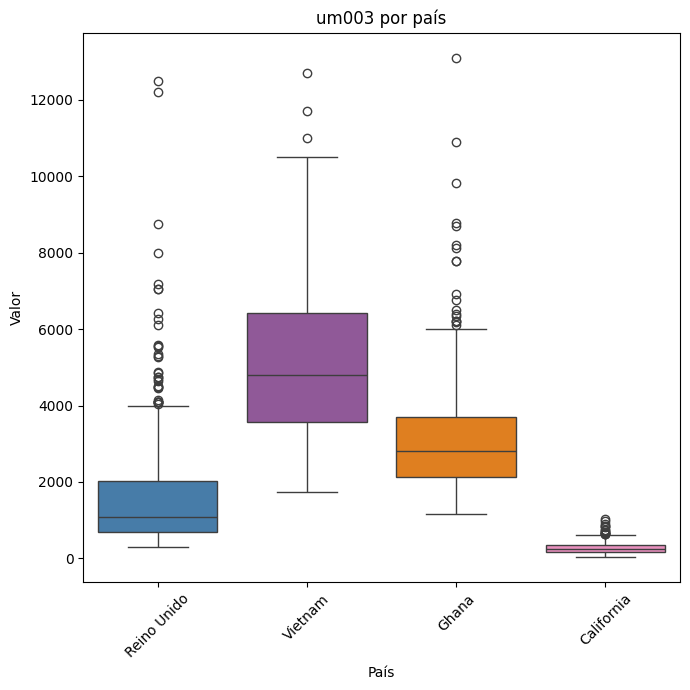

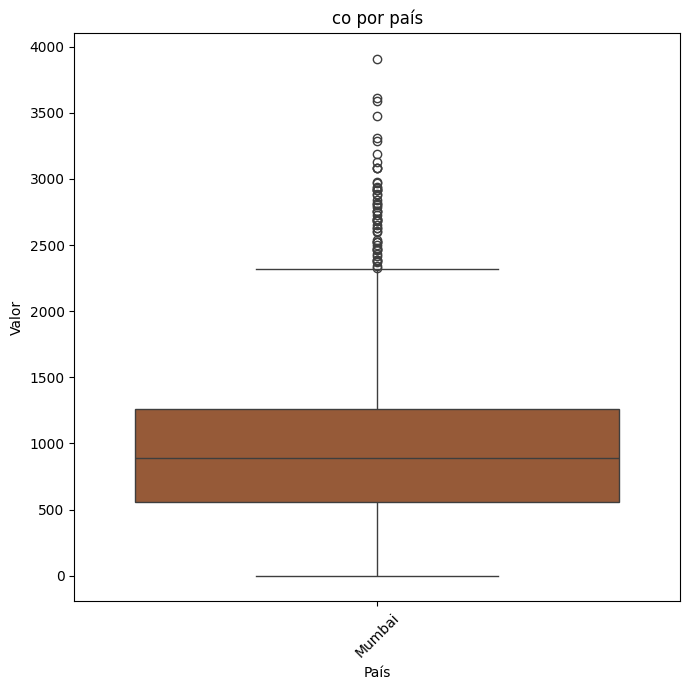

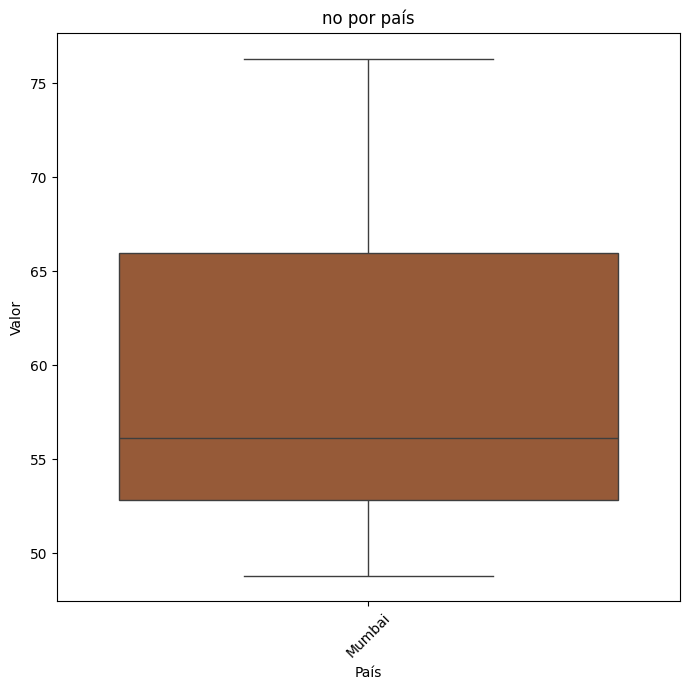

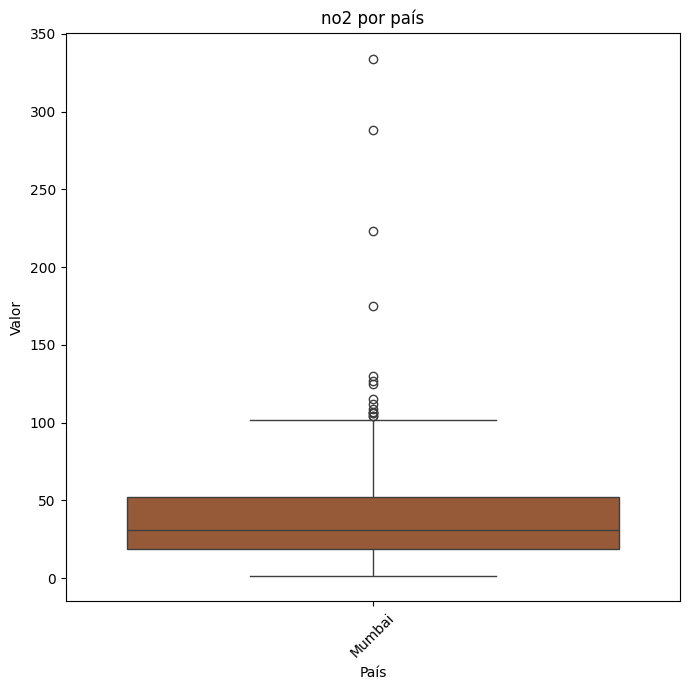

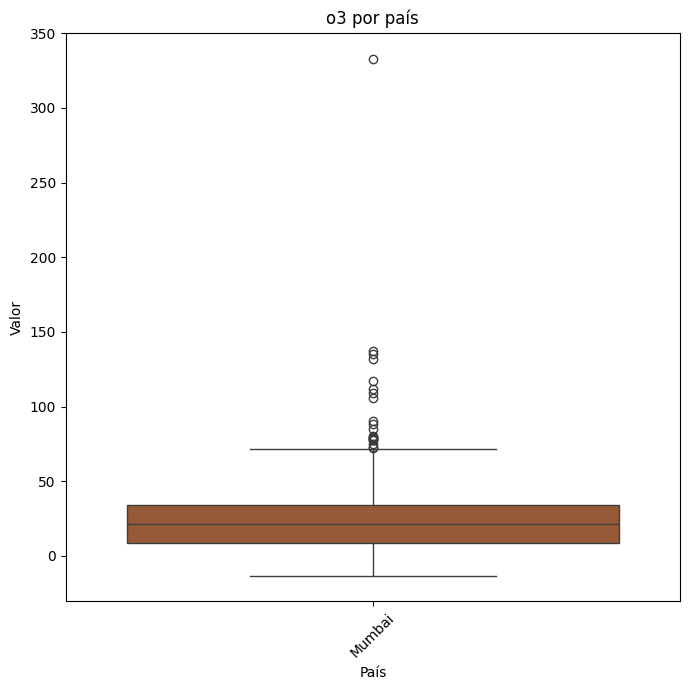

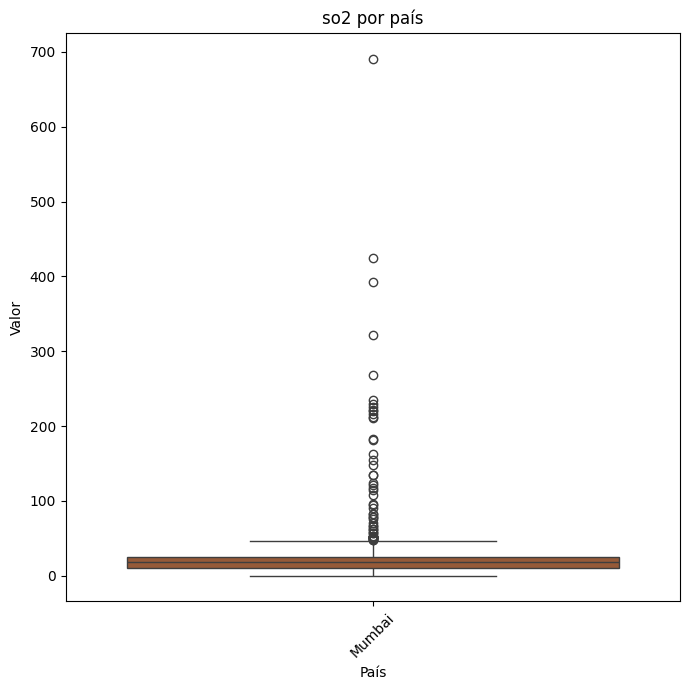

In [284]:
all_dfs = pd.concat(locations_dfs, ignore_index=True)
different_parameters = all_dfs["parameter_name"].unique()

for i, parameter in enumerate(different_parameters):
    plt.figure(figsize=(7, 7))
    plt.title(f"{parameter} por país")
    plt.xlabel("País")
    plt.ylabel("Valor")
    plt.xticks(rotation=45)
    sns.boxplot(
        x="country_name",
        y="value",
        hue="country_name",
        data=all_dfs[all_dfs["parameter_name"] == parameter],
        palette=locations_color_map
    )
    plt.tight_layout()

plt.show()

### Visualización de cada parámetro, en el mapa

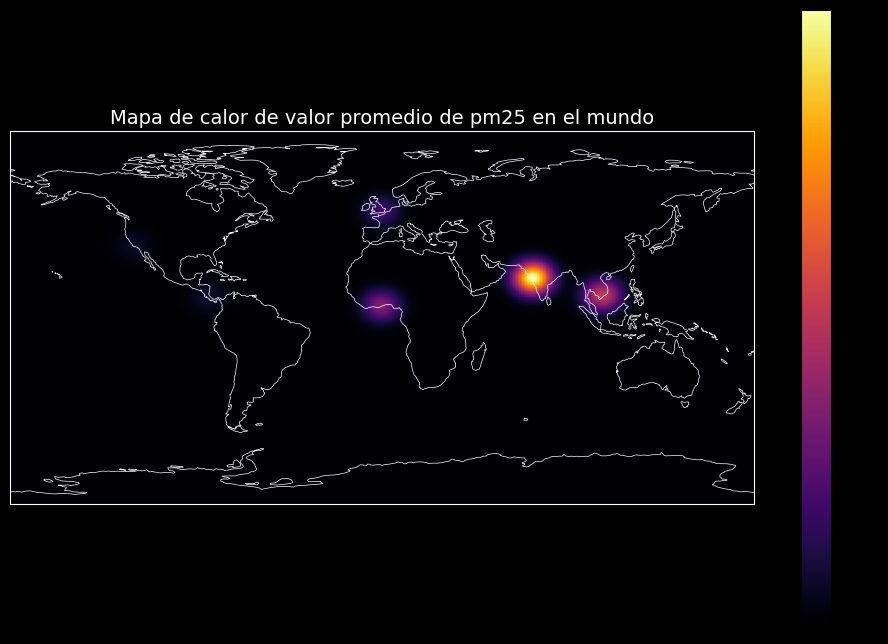

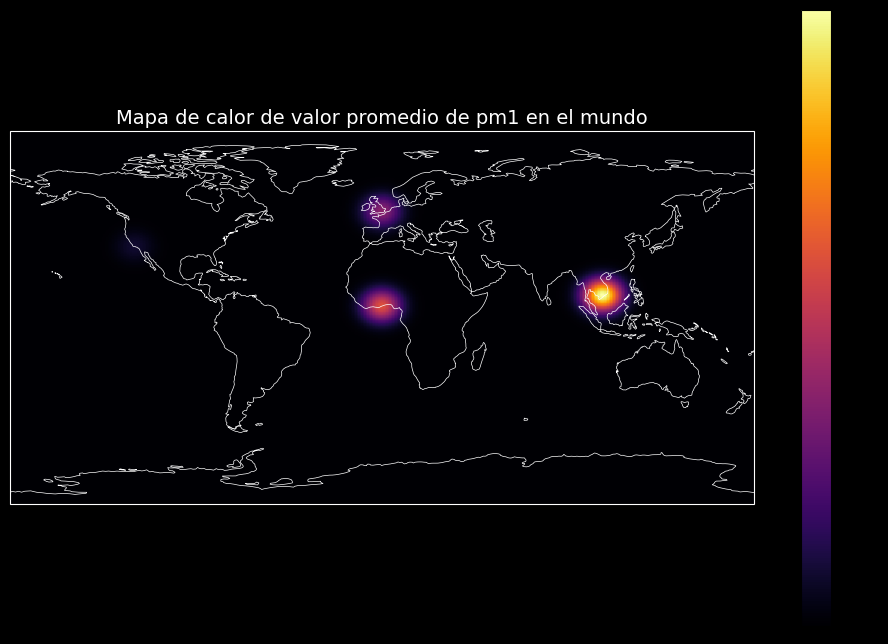

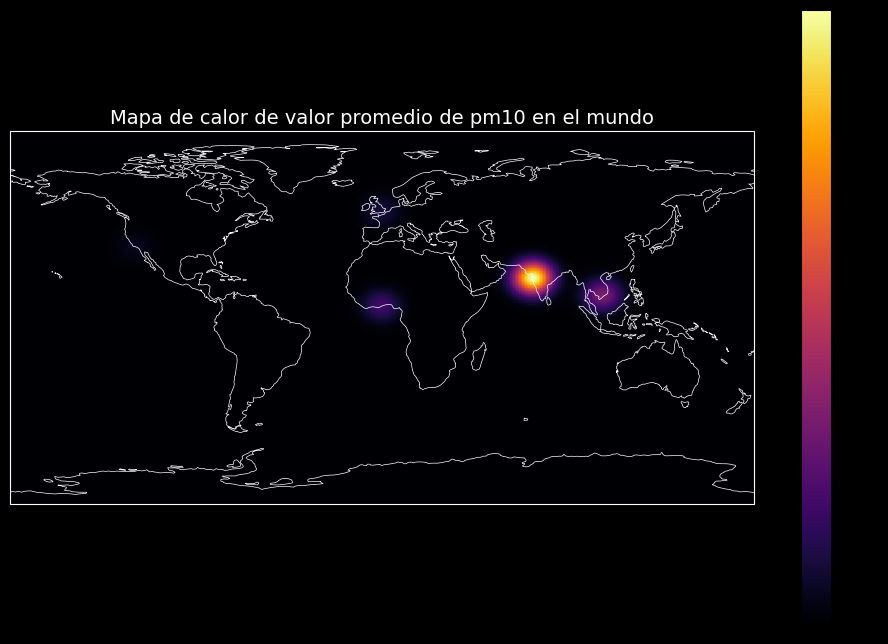

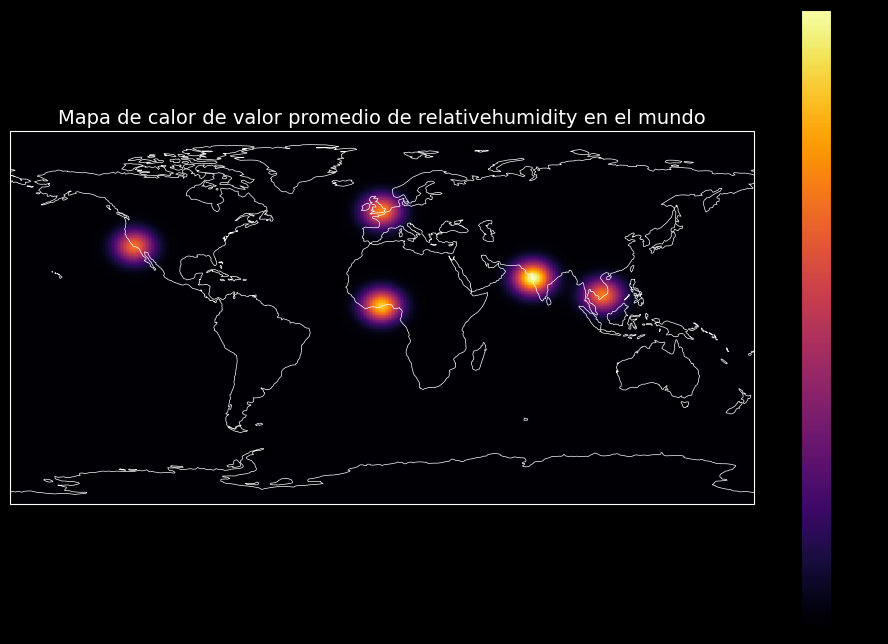

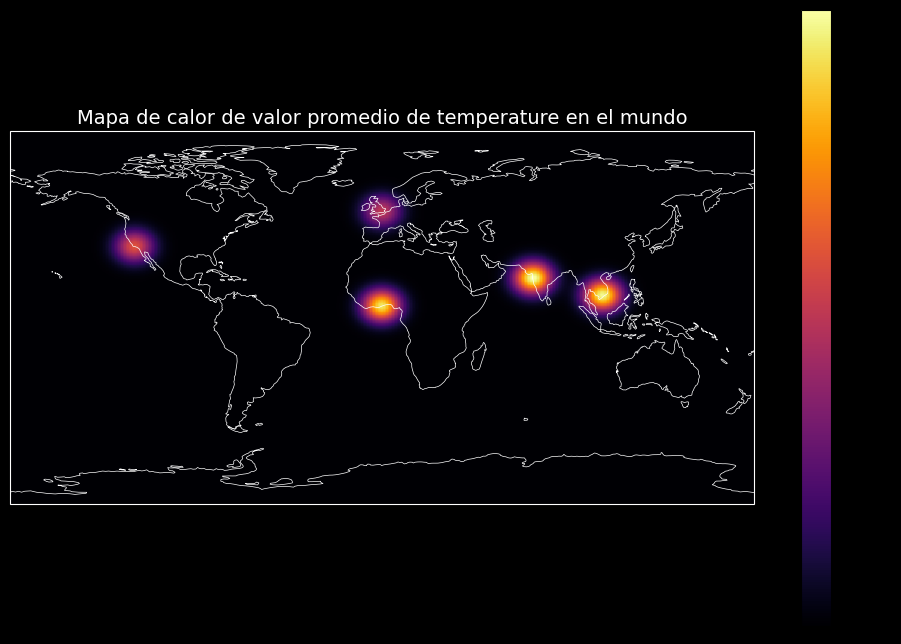

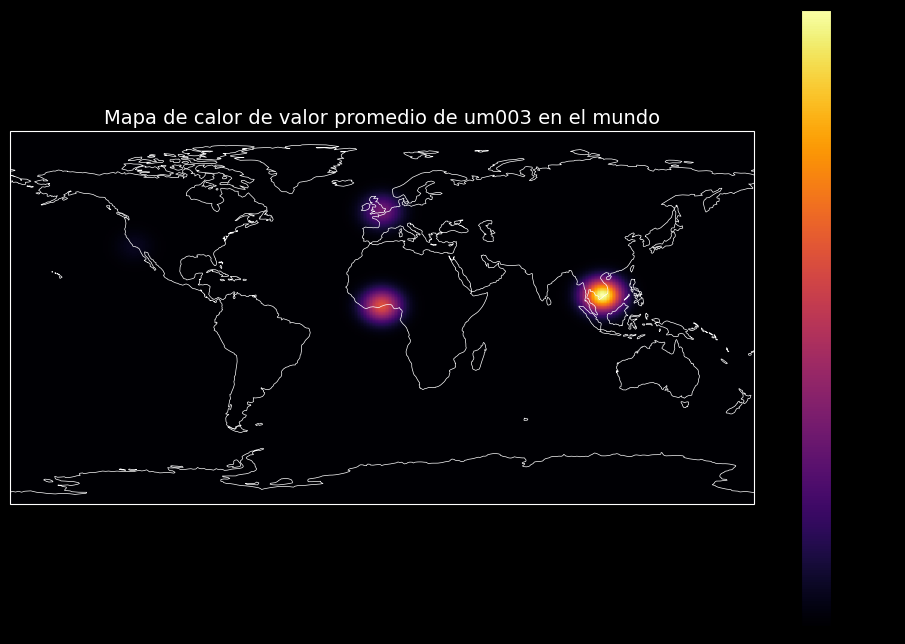

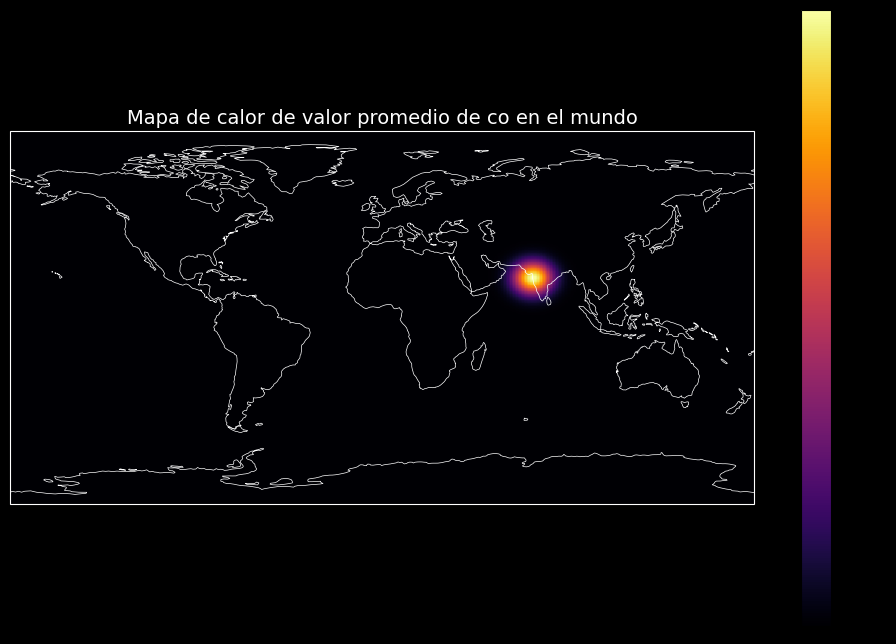

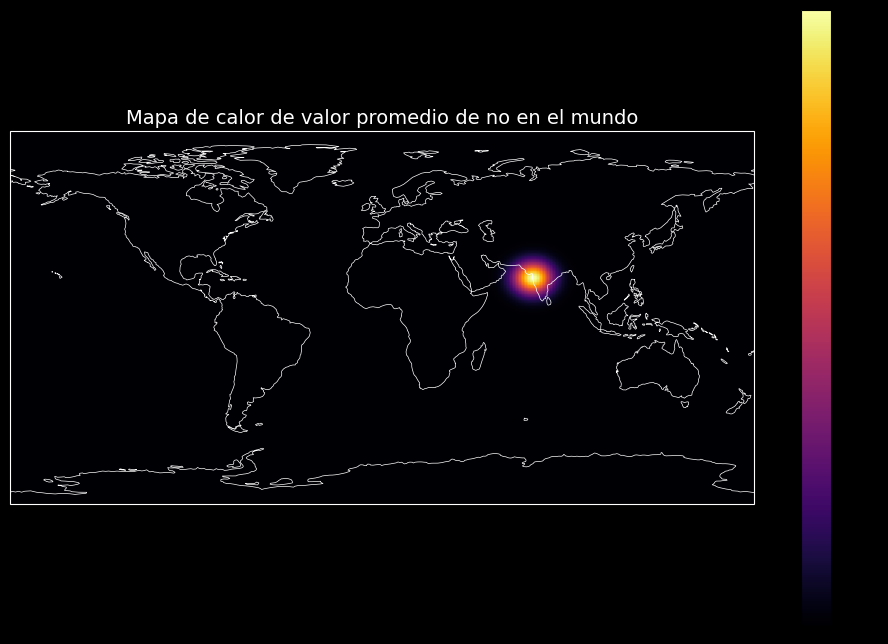

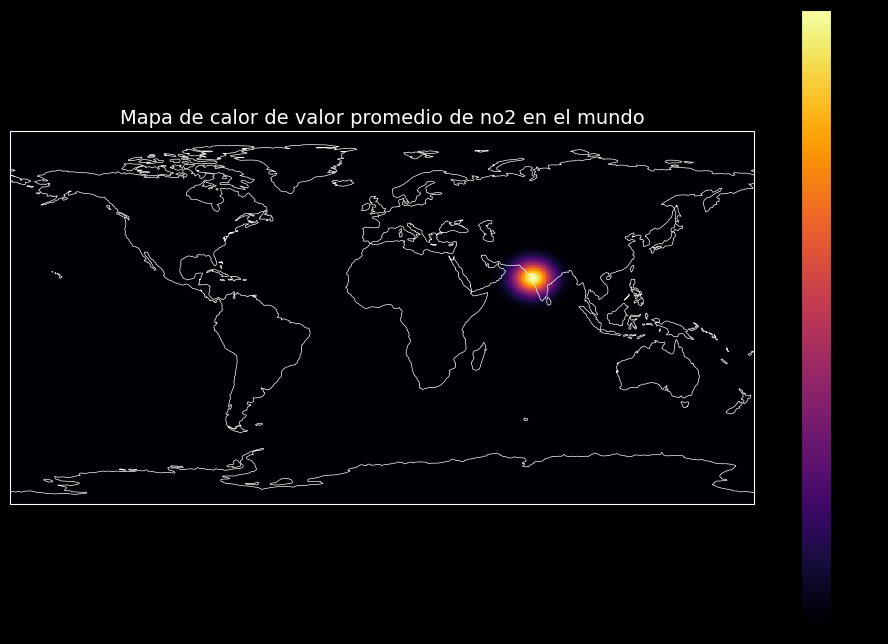

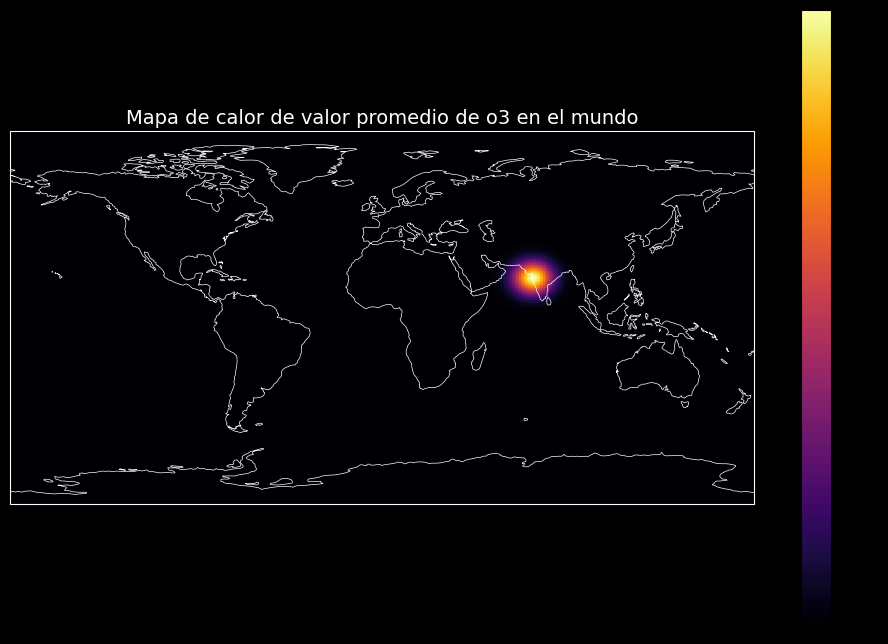

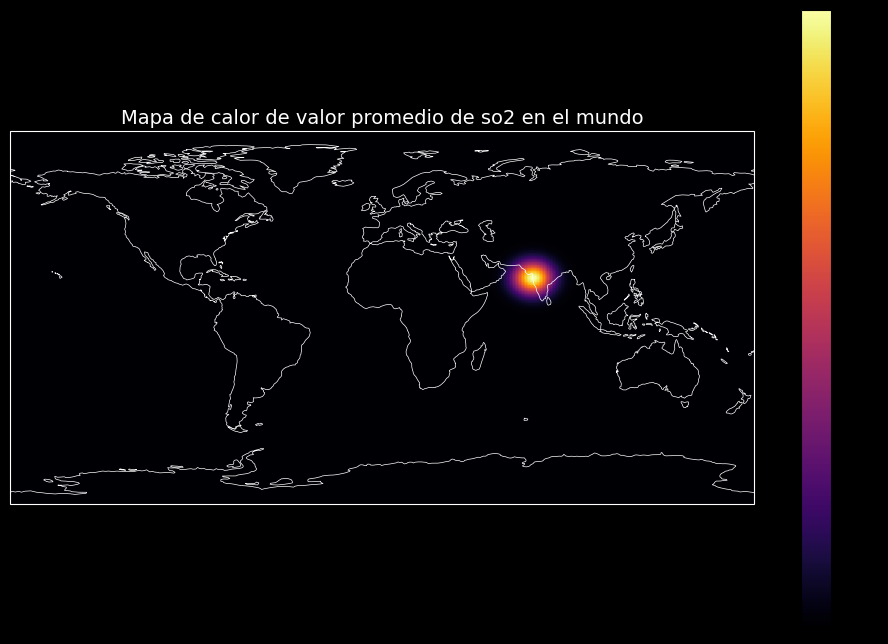

In [347]:
for parameter in different_parameters:
    # Obtenemos el promedio del valor por localizacion
    grouped = all_dfs[all_dfs["parameter_name"] == parameter].groupby('country_name')['value'].mean()

    # Ordenamos los valores
    sorted_locations = sorted(locations, key=lambda x: x.country)
    lons, lats, values = [], [], []
    for loc in sorted_locations:
        if loc.country in grouped.index:
            lons.append(loc.coordinates['longitude'])
            lats.append(loc.coordinates['latitude'])
            values.append(grouped[loc.country])

    # Crear una malla regular para la interpolación
    grid_lon = np.linspace(-180, 180, 500)  # Longitudes que cubren todo el mundo
    grid_lat = np.linspace(-90, 90, 500)    # Latitudes que cubren todo el mundo
    grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

    # Creamos una matriz vacía para los valores de contaminación
    grid_values = np.zeros_like(grid_lon)

    # Rellenamos la matriz de contaminación con los valores en las ubicaciones especificadas
    for lon, lat, value in zip(lons, lats, values):
        # Calculamos la distancia radial para crear una difusión circular
        distance = np.sqrt((grid_lon - lon)**2 + (grid_lat - lat)**2)

        # Aplicamos una "función gaussiana" para crear la difusión alrededor del punto
        grid_values += value * np.exp(-distance**2 / (2 * 5**2))  # Aumentamos el radio de difusión

    # Aplicamos un filtro gaussiano para suavizar la distribución de los valores
    grid_values = gaussian_filter(grid_values, sigma=6)  # Aumentamos sigma para mayor suavizado

    # Crear la figura con un tamaño adecuado
    fig = plt.figure(figsize=(12, 8), dpi=100)  # Ajustamos el tamaño a 12x8
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Mostrar las costas del mundo
    ax.coastlines(color='white', linewidth=0.5)

    # Fondo oscuro
    ax.set_facecolor('black')

    # Mostrar el mapa de calor suavizado con un nuevo colormap 'inferno'
    c = ax.pcolormesh(grid_lon, grid_lat, grid_values, cmap='inferno', shading='auto', transform=ccrs.PlateCarree())

    # Añadir barra de color
    plt.colorbar(c, ax=ax, orientation='vertical', label='Nivel de Contaminación')

    # Título
    plt.title(f'Mapa de calor de valor promedio de {parameter} en el mundo', fontsize=14, color='white')

    # Cambiar color de texto y ejes a blanco para fondo oscuro
    plt.gcf().patch.set_facecolor('black')  # Fondo de la figura
    for spine in ax.spines.values():
        spine.set_color('white')

    # Guardamos la imagen
    plt.show()


# 4. Análisis y comparación:

Se debe realizar un análisis EDA que incluya análisis univariable y multivariable.

Analizar las tendencias de los indicadores para las diferentes ciudades y hacer comparaciones entre diferentes países y ciudades.

Incluir posibles correlaciones entre las variables y parámetros de calidad del aire de cada país/ciudad.

Utilizar diferentes tipos de visualizaciones relevantes para el análisis.


### Descripción inicial de los datos

Podemos analizar los datos inicialmente con las funciones que ofrecen los pandas DF.

In [ ]:
locations_dfs = [pd.read_csv(f"{location.file_path}.csv") for location in locations]


# 5. Conclusiones y Recomendaciones:

Extraer conclusiones sobre la evolución de la calidad del aire en Costa Rica y las ciudades seleccionadas, explicando cómo los datos sustentan estas conclusiones.

Buscar información sobre las políticas ambientales y regulaciones en estas ciudades y mostrar cómo los datos reflejan el efecto de estas políticas.